In [1]:
# Import du script gmc_project\n",
# Attention, il faut que ton jupyter notebook (le fichier que t'es en train de lire) soit situé dans le répertoire src de GeoMultiCorr (Je ne sais plus où tu l'as installé sur ton pc)\n",
import gmc_project

# Création d'un objet de la classe GMC_Project, elle même écrite dans le script gmc_project qu'on a importé juste avant
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')

# Au niveau du projet, on peut récupérer différents trucs
paires_interessantes = etude.get_pairs([2018,2014,'mont-vallon'])
#thumbs_interessantes = etude.get_thumbs([2019, 'aerial'])
paires_interessantes
# Si on récupére une paire en particulier
#paire_interet = paires_interessantes[0]


# On peut récupérer d'autres choses à ce niveau
#disparity = paire_interet.get_dispf_geoim()

#disparity_resized = disparity.resize(10, method = 'average')

---------
telenvi 5.0.2
---------
---------
GeoMultiCorr 0.0.0
---------


AssertionError: adresse invalide

In [16]:
disparity.getPixelSize()

# Extraire la matrice d'un geoim
matrice_disparity = disparity.array
print(matrice_disparity)
# Connaitre les dimensions d'une matrice
matrice_disparity.shape

# Récupérer une bande en particulier
dx = matrice_disparity[0]
dy = matrice_disparity[1]
print(dx.shape)
print(dy.shape)

# Récupérer les valeurs de matrice de geoim en fonction de coordonnées carto
disparity.getPointValue((982321,6476414))

enumerate(matrice_disparity)
list(enumerate(matrice_disparity))

(1.0, -1.0)

In [5]:
import gmc_project
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import shutil

def production_couche_vecteur_depl(paire_images, facteur_redimensionnement_pixels) :
    if paire_images.pa_status == 'complete' :
        #extraction matrice de disparités
        disparity_initiale = paire_images.get_dispf_geoim() 
        disparity = disparity_initiale.resize(facteur_redimensionnement_pixels, method = 'average')
        matrice_disparity = disparity.array

        #extraction caract paire et formatage du nom de la couche de sortie
        x = paire_images
        yleft = x.pa_left.th_year
        yright = x.pa_right.th_year
        yleft, yright
        x.pa_path
        nom_fichier = f'{x.pa_path}/vector_{yleft}-{yright}-{facteur_redimensionnement_pixels}.shp'

        #symbologie
        style_initial = '/home/gaiani/Documents/STAGE/mont-vallon/style_fleches.qml'
        copie = x.pa_path
        shutil.copy2(style_initial, copie)
        os.rename(f'{x.pa_path}/style_fleches.qml',f'{x.pa_path}/vector_{yleft}-{yright}-{facteur_redimensionnement_pixels}.qml')

        #extraction caractéristiques GeoIm
        (Ox,Oy) = disparity.getOrigin()  
        (Pix_X,Pix_Y) = disparity.getPixelSize()  
        (NombreBande,Nombreligne,Nombrecol) = disparity.getShape()  

        #création de deux matrices de coordonnés X et Y des pixels
        MatCoorX = np.arange(Ox,Ox + Pix_X*Nombrecol, Pix_X)  
        MatCoorY = []
        MatCoorY.append([l for l in np.arange(Oy,Oy + Pix_Y*Nombreligne, Pix_Y)]) 

        #extraction valeurs des pixels
        data = [] 
        for numLigne,Ligne in enumerate(matrice_disparity[0]) :
            for numColon,Colon in enumerate(Ligne) :
                dx = matrice_disparity[0][numLigne][numColon]  
                dy = -matrice_disparity[1][numLigne][numColon]
                data.append([dx,dy,MatCoorX[numColon],MatCoorY[0][numLigne]])  

        #conversion en dataframe -> geodataframe -> couche vecteur
        dataf = pd.DataFrame(data)
        dataf.columns = ['dx', 'dy','CoorX','CoorY']  
        gdf = gpd.GeoDataFrame(dataf, geometry=gpd.points_from_xy(dataf.CoorX, dataf.CoorY), crs = {'init' : 'epsg:2154'})
        gdf.to_file(nom_fichier, driver = 'ESRI Shapefile')

In [6]:
    # Création d'un objet de la classe GMC_Project, elle même écrite dans le script gmc_project qu'on a importé juste avant
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
paires_interessantes = etude.get_pairs()
for resize in [5,10] : 
        for index,paire_interet in enumerate(paires_interessantes) :
            production_couche_vecteur_depl(paires_interessantes[index],resize)

In [7]:
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
data = etude.get_pairs()
from telenvi import raster_tools as rt
def generation_raster(data):
    for pair_image in data :
        if pair_image.pa_status == 'complete' :
            target = pair_image.pa_dispf_path
            target_bis = pair_image.pa_magn_path
            yleft = pair_image.pa_left.th_year
            yright = pair_image.pa_right.th_year
            dossier_pair = pair_image.pa_path
            donnees_pair = pair_image.pa_key
            for elem in [1,2] : 
                bande_interet = rt.pre_process(target,nBands = elem, geoim = True)
                geoim_vitesse = bande_interet / abs(yright - yleft)
                if elem == 1 :
                    geoim_vitesse.save(f'{dossier_pair}/{donnees_pair}_vx.tif')
                else: 
                    geoim_vitesse.save(f'{dossier_pair}/{donnees_pair}_vy.tif')
            magn = rt.pre_process(target_bis, geoim = True)
            geoim_magn_vitesse = magn / abs(yright - yleft)
            geoim_magn_vitesse.save(f'{dossier_pair}/{donnees_pair}_v.tif')

generation_raster(data)

In [1]:
import gmc_project
import geopandas as gdp
from telenvi import raster_tools as rt
import numpy as np
import gmc_pair
import pandas as pd
import matplotlib.pyplot as plt
import gmc_geomorph
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')

from matplotlib import pyplot as plt
#plt.imshow(matrice)

etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')


def recup_zone_etude(statut_zone, index_zone):
    
    # Récupère layer zones d'extraction - contient des stables et des mouvantes
    xz = etude._xzones

   # Selectionne les zones au statut x(stables, mouvantes...) dans le layer d'extraction
    statut = xz[xz.statut == str(statut_zone)]

    #recupere un polygone en particulier (index)
    xz_etudiee = statut.iloc[index_zone]

    return xz_etudiee

def mask_raster_depl_par_corr(paire,elem, statut_zone, index_zone) :

    z_cible = recup_zone_etude(statut_zone, index_zone)

    # Récupère la carte des correlations valides (1) et invalides (0) sous forme de GeoIm
    good_pixel_map = paire.get_disp_corr_geoim()

    # Récupère le raster de déplacemets de la paire
    # Ouvre le raster de déplacement v, vx ou vy de la paire
    if elem == 'v':
        disp_cible = paire.get_vmagn_geoim()
    elif elem == 'vx':
        disp_cible = paire.get_vx_geoim()
    elif elem == 'vy':
        disp_cible = paire.get_vy_geoim()

    disp_cible = disp_cible.cropFromVector(z_cible.geometry) #découpe selon l'emprise
    disp_cible.maskFromVector(z_cible.geometry)
    nbre_pixels_valides_1_masque = disp_cible.array.count()


    # Découpe le geoim de correlations sur l'emprise de la zone
    good_pixel_map = good_pixel_map.cropFromVector(z_cible.geometry)

    # Extrait la matrice de ce geoim
    ar_good_pixel_map = good_pixel_map.array

    # 3 lignes suivantes pour intervertir les 0 et les 1 sur l'ar_good_pixel_map
    # Et en faire masque utilisable dans une masked_array

    # Transforme les valeurs 0 en 999
    ar_good_pixel_map[ar_good_pixel_map==0] = 999

    # Transforme les 1 en 0
    ar_good_pixel_map[ar_good_pixel_map==1] = 0

    # Transforme les 999 en 1
    ar_good_pixel_map[ar_good_pixel_map==999] = 1

    # Utilisation de cette matrice binaire pour masquer le raster de déplacements
    disp_cible.array = np.ma.masked_array(
        data = disp_cible.array,
        mask = ar_good_pixel_map)
    
    nbre_pixels_valides_2_masques = disp_cible.array.count()

    
    #lignes suivantes pour filtrer les résultats
    #si plus de 50% du polygone est conservé, on garde 
    if nbre_pixels_valides_2_masques > 0.5 * nbre_pixels_valides_1_masque:
        return disp_cible
    

    #est alors masquée par le masque de corrélation et le maskFromVector (avoir valeurs sur z_etude)


def vitesse_par_zone(etude, year_debut, year_fin, statut_zone, index_zone) :
    
    """
    Toutes les données utiles sont récupérées depuis la variable passée dans l'argument 'etude'
    """
    data = etude.get_pairs_on_period(year_debut, year_fin)
    donnees_vitesses = []
    annees_paires = []
    nombre_paires_completes = 0
    for paire_interessante in data :
        don_vit = []

        #on parcourt les paires au statut valide, qu'on compte
        if paire_interessante.pa_status == 'complete':
            nombre_paires_completes += 1 

            #annees_paires contient la liste des duos d'années des paires
            annees_paires.append(f'{(paire_interessante.pa_left.th_date)[0:4]}-{(paire_interessante.pa_right.th_date)[0:4]}')

            debug = 0
            for elem in ['v', 'vx', 'vy'] :
                zone_interet = mask_raster_depl_par_corr(paire_interessante,elem, statut_zone, index_zone)
                
                if zone_interet is not None :

                #moyenne des valeurs de vitesse des pixels sur la zs
                    don_vit += [zone_interet.mean()]
                
                else :
                    debug = 1

            #debug devient 1 si zone_interet est un NoneType object : il faut supprimer la paire d'années ajoutée de la liste
            if debug  == 1 : 
                annees_paires.pop()

            #liste avec v, vx, vy pour chaque paire d'image
            donnees_vitesses += [don_vit] 
    
    #lignes suivantes pur supprimer sous-listes vides de données_vitesses
    x = []
    while x in donnees_vitesses:
        donnees_vitesses.remove(x)
    df = pd.DataFrame(donnees_vitesses,index = annees_paires, columns=['v','vx','vy'])
    df.index.name="Paire"
    return df


def tri_paires(etude,year_debut,year_fin,index_zone):

    "trie les paires d'images : supprime les paires qui ont une vitesse moyenne plus élevée en zone stable "
    "qu'en zone mouvante"

    #création d'un df qui contient v_z_mouv - v_z_stable
    vit_mouvement = vitesse_par_zone(etude,year_debut,year_fin,'mouvement',index_zone)
    vit_stable = vitesse_par_zone(etude,year_debut,year_fin,'stable',0) 
    dif_vit_periode = vit_mouvement - vit_stable 
    
    #suppression dans le df de difference de vitesses des paires où v_z_stable > v_z_mouv
    dif_vit_periode.drop(dif_vit_periode[(dif_vit_periode['v'] < 0)].index, inplace=True)

    #suppression des lignes avec valeur NaN (zone stable ou zone mouvante sans données donc différence ne marche pas)
    index_with_nan = dif_vit_periode.index[dif_vit_periode.isnull().any(axis=1)]
    dif_vit_periode.drop(index_with_nan,0, inplace=True)

    #on récupère les paires valides
    liste_paires_valides = dif_vit_periode.index.to_list()

    #on récupère les données de vitesse des paires valides dans le df initial
    vit_mouvement_valide = vit_mouvement.loc[liste_paires_valides]
    vit_mouvement_valide.to_csv(f"dataframe_tri_paires_{index_zone}.csv", sep = ',')


    return vit_mouvement_valide


---------
telenvi 5.0.3
---------
---------
GeoMultiCorr 0.0.0
---------


In [4]:
tri_paires(etude,2001,2021,0)
tri_paires(etude,2001,2021,1)
tri_paires(etude,2001,2021,2)


ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/pr

,v,vx,vy
Paire,,,
2001-2006,2.100906,-1.780699,-1.108243
2001-2013,0.208144,-0.079404,-0.177452
2001-2014,0.993477,-0.498370,-0.858773
2001-2017,1.116335,-0.621874,-0.926042
2001-2018,1.018911,-0.508664,-0.882493
2001-2019,0.298809,0.085390,-0.182309
2001-2021,0.955712,-0.488649,-0.820737
2006-2009,0.834281,-0.796518,-0.242185
2006-2013,0.553809,0.334491,0.013722


In [3]:
xz = etude._xzones

# Selectionne les zones au statut x(stables, mouvantes...) dans le layer d'extraction
statut = xz[xz.statut == str('mouvement')]
statut

,xz_id,xz_pz_name,statut,geometry
1,0,NaN,mouvement,"POLYGON ((982246.117 6476718.878, 982247.489 6..."
2,1,NaN,mouvement,"POLYGON ((982202.521 6476762.521, 982204.020 6..."
3,2,NaN,mouvement,"POLYGON ((982140.871 6476799.061, 982142.430 6..."
4,3,NaN,mouvement,"POLYGON ((981870.490 6476744.756, 981871.886 6..."
5,4,NaN,mouvement,"POLYGON ((981916.287 6476710.981, 981917.723 6..."
6,5,NaN,mouvement,"POLYGON ((981962.525 6476672.265, 981964.025 6..."


In [4]:
pd.read_csv('/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_tri_paires.csv')

,Paire,v,vx,vy
0,2001-2006,2.353483,-2.125143,-0.833199
1,2001-2013,0.277636,-0.102463,-0.245635
2,2001-2014,0.291458,-0.203191,-0.188849
3,2001-2018,0.617349,-0.415283,-0.455879
4,2001-2019,0.259584,-0.125620,-0.215370
5,2001-2021,0.542681,-0.371617,-0.392051
6,2006-2009,0.920857,0.913353,-0.079882
7,2006-2013,1.070187,0.965412,0.289383
8,2006-2014,0.166136,0.061806,-0.135055
9,2006-2018,0.184432,-0.061894,-0.121459


In [8]:
# le csv est issu de la fonction tri_paires pour la période 2001-2021

import pandas as pd
import numpy as np

def lecture_csv(chemin_csv) :
    return pd.read_csv(chemin_csv)

def tot_annees_etude(chemin_csv) : 
    #retourne toutes les années d'étude des paires issues de tri_paires


    lire = lecture_csv(chemin_csv)
    L = []
    for annees in lire['Paire']:
        if annees[0 : 4] not in L:
            L.append(annees[0 : 4])
        if annees[0 : 4] not in L:
            L.append(annees[0 : 4])
    for annees in lire['Paire']:
        if annees[5 : 9] not in L:
            L.append(annees[5 : 9])
        if annees[5 : 9] not in L:
            L.append(annees[5 : 9])
    return L

def selection_paire_avt_tri_med(chemin_csv,binf,bsup) :
    lire = lecture_csv(chemin_csv)

    #liste de toutes les années entre les 2 bornes de la période étudiée
    ye = np.arange(float(binf),float(bsup) + 1, 1)
    L = []
    for paire in lire['Paire'] :
        # Bornes de la paire
        yminp = min(int(paire[0:4]),int(paire[5:9]))
        ymaxp = max(int(paire[0:4]),int(paire[5:9]))

        # Déroule toutes les années entre les bornes de la paire
        yp = np.arange(yminp, ymaxp+1, 1)

        # Détermine si une paire est intéressante au regard de la période d'étude
        y_common = np.intersect1d(yp, ye)

        #sélection des paires avec au moins 2 années en commun, sinon sélectionne aussi 
        # les paires ayant juste en commun la borne sup de la période d'étude
        if len(y_common) > 1: 
            L.append(paire)
    return L

def tri_paires_par_ecart_med(chemin_csv,binf,bsup, seuil_med) :

    #entrée : paires incluses dans la période étudiée; sortie : moyenne des vitesses des paires non éliminées par écart à la médiane
    lire = lecture_csv(chemin_csv)

    #on sélectionne les paires d'années intéressantes
    paires_interessantes = selection_paire_avt_tri_med(chemin_csv, binf, bsup)
    if len(paires_interessantes) != 0 :
        liste_vit = []

        for paire in paires_interessantes:

            #on stocke la valeur de vitesse associée à chaque paire d'années 
            liste_vit.append(lire[lire['Paire'] == str(paire)]['v'])

        #on dét la médiane des vitesses des paires étudiées
        med = np.median(liste_vit)
        liste_vit_valides = []

        for paire in paires_interessantes:

            vit = float(lire[lire['Paire'] == str(paire)]['v'])

            #on conserve une valeur v si elle est inclue dans un certain écart à la médiane
            if seuil_med * med <= vit <= (1+seuil_med) * med :
                liste_vit_valides.append(vit)

        #on fait la moyenne des valeurs de vitesse restantes : vitesse moyenne de deplacement sur
        #  le polygone et la période étudiés
        return np.mean(liste_vit_valides)
    else :
        return None

def donnees_vitesse_finales_zM(chemin_csv, seuil_med):
    liste_periodes = [[2001,2006],[2006,2009],[2009,2013],[2013,2014],[2014,2017],[2017,2018],[2018,2019],[2019,2021]]
    donnees_vitesses = []
    liste_periodes_bis = []

    #on parcourt la liste d'années
    for  index,periode in enumerate(liste_periodes):

            #liste des périodes d'étude, future colonne du df
            liste_periodes_bis.append(f"{liste_periodes[index][0]}-{liste_periodes[index][1]}")

            #v_moyenne sur période donnée en éliminant mauvaises paires avec écart à med donné
            v_moyenne = tri_paires_par_ecart_med(chemin_csv,periode[0],periode[1],seuil_med)
            if type(v_moyenne) == None :
                donnees_vitesses.append(None)
            else : 
                donnees_vitesses.append(v_moyenne)

    #df avec vitesse moyenne sur polygone de zone mouvante sur toutes les périodes
    df = pd.DataFrame(donnees_vitesses,index = liste_periodes_bis, columns=['v_moy'])
    return df
    
def donnees_vitesse_finales_zS(chemin_csv):
        liste_periodes = [[2001,2006],[2006,2009],[2009,2013],[2013,2014],[2014,2017],[2017,2018],[2018,2019],[2019,2021]]
        donnees_vitesses= []
        liste_periodes_bis = []
        donnees_vitesses_medianes = []


    #chemin_csv le csv de vitesses en zone stable, qui n'a pas subi le traitement de tri par différence entre zones de mouvement et zone stable
        lire = lecture_csv(chemin_csv)


        for  index,periode in enumerate(liste_periodes):

            liste_periodes_bis.append(f"{liste_periodes[index][0]}-{liste_periodes[index][1]}")

            #sélection des paires avec période incluse dans periode
            paires_interessantes = selection_paire_avt_tri_med(chemin_csv, periode[0], periode[1])

            if len(paires_interessantes) != 0 :
                for paire in paires_interessantes:

                #on stocke la valeur de vitesse associée à chaque paire d'années 
                    donnees_vitesses.append(lire[lire['Paire'] == str(paire)]['v'])

            #contient médiane des vitesses des paires valides sur la période étudiée
            donnees_vitesses_medianes.append(np.median(donnees_vitesses))

        #contient vitesses médiane en zs par période
        df = pd.DataFrame(donnees_vitesses_medianes, index = liste_periodes_bis, columns=['v_moy'])
        return df  


In [9]:

donnees_vitesse_finales_zM('/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_tri_paires_0.csv',0.5), donnees_vitesse_finales_zM('/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_tri_paires_1.csv',0.5),donnees_vitesse_finales_zM('/home/gaiani/Documents/STAGE/GeoMultiCorr/src/dataframe_tri_paires_2.csv',0.5),donnees_vitesse_finales_zS('/home/gaiani/Documents/STAGE/GeoMultiCorr/src/vitesse_zS.csv')

(              v_moy
 2001-2006  0.373674
 2006-2009  0.356057
 2009-2013  0.600967
 2013-2014  0.631207
 2014-2017  0.633397
 2017-2018  0.679341
 2018-2019  0.728583
 2019-2021  0.710483,
               v_moy
 2001-2006  0.352077
 2006-2009  0.383952
 2009-2013  0.491599
 2013-2014  0.541328
 2014-2017  0.700086
 2017-2018  0.775959
 2018-2019  0.880695
 2019-2021  0.859764,
               v_moy
 2001-2006  0.475107
 2006-2009  0.458912
 2009-2013  0.449955
 2013-2014  0.439448
 2014-2017  0.726494
 2017-2018  0.775097
 2018-2019  0.792378
 2019-2021  0.768720,
               v_moy
 2001-2006  0.183350
 2006-2009  0.158703
 2009-2013  0.160116
 2013-2014  0.178329
 2014-2017  0.183350
 2017-2018  0.178329
 2018-2019  0.178329
 2019-2021  0.161985)

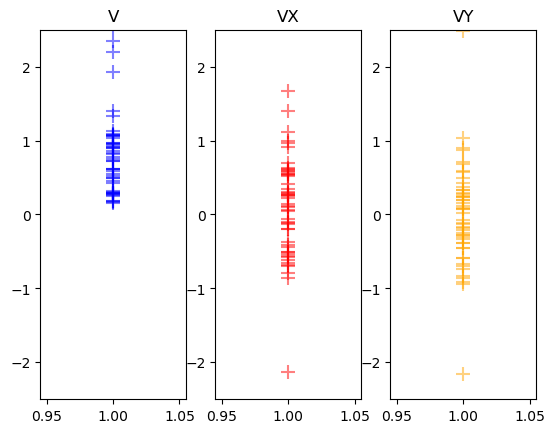

In [90]:
def visualisation_graphique(df) :
    
    # visualisation résultats en nuage de points
    low,max = -2.5, 2.5
    fig, axs = plt.subplots(1,3)
    x_std = [1 for x in range(len(df))]
    gv, gvx, gvy = axs
    axs = [gv, gvx, gvy]
    color = ['blue','red','orange']
    titre = ['V','VX','VY']
    i = 0
    for elem in [df.v,df.vx,df.vy] :
        axs[i].scatter(x_std, elem, c=color[i], s=100, alpha=0.5, marker='+')
        axs[i].set_title(titre[i])
        axs[i].set_ybound((low,max))
        i += 1 

visualisation_graphique(a)

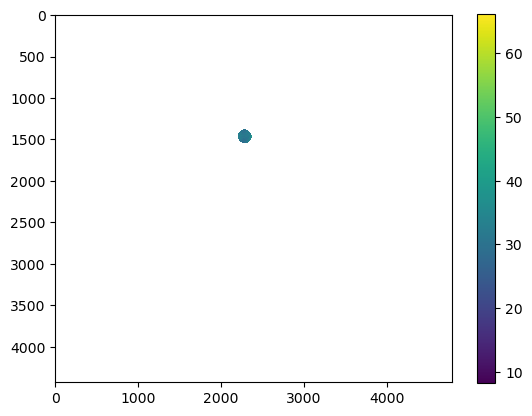

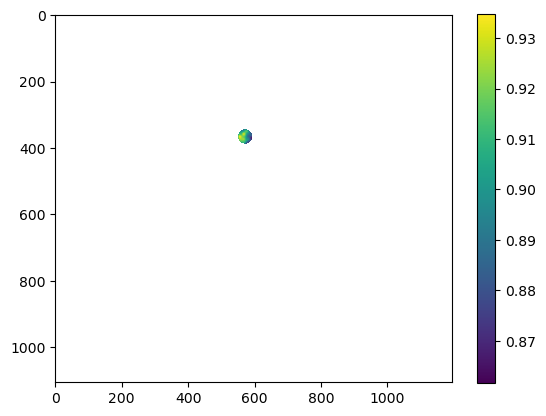

In [101]:
chemin_raster_bis = "/home/gaiani/Documents/STAGE/mont-vallon/pente_mont_vallon.tif"
poly = recup_zone_etude('mouvement',0)

pente = rt.pre_process(chemin_raster_bis, geoim = True)
pente.maskFromVector(poly.geometry)
p_bis = pente.array

paire = etude.get_pairs(['2014','2018'])[0]
a = paire.get_vmagn_geoim()
a.maskFromVector(poly.geometry)
a.show() 

